In [1]:
import nibabel as nib
import numpy as np
from os.path import join
import math
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests
from nilearn import plotting
from nilearn.image import resample_to_img

from scipy import ndimage
from scipy.spatial.distance import cdist
from scipy.sparse import csgraph
import cvxpy as cp
from sklearn.model_selection import KFold
from itertools import product
import scipy.io as sio
import h5py
from sklearn.decomposition import PCA
import scipy.sparse as sp
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from scipy.stats import zscore

In [2]:
import numpy as np
import nibabel as nib
from os.path import join

ses = 1
sub = '04'
run = 1

base_path = '/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives'

# Load images without forcing full data into memory when not needed
anat_path = f'{base_path}/sub-pd0{sub}/ses-{ses}/anat/sub-pd0{sub}_ses-{ses}_T1w_brain.nii.gz'
anat_img = nib.load(anat_path) 
print(anat_img.shape)

data_name = f'sub-pd0{sub}_ses-{ses}_run-{run}_task-mv_bold_corrected_smoothed_reg.nii.gz'
BOLD_path_org = join(base_path, f'sub-pd0{sub}', f'ses-{ses}', 'func', data_name)
bold_img = nib.load(BOLD_path_org)
bold_data = bold_img.get_fdata()

mask_base = f'{base_path}/sub-pd0{sub}/ses-{ses}/anat'

brain_mask_path = f'{mask_base}/sub-pd0{sub}_ses-{ses}_T1w_brain_mask.nii.gz'
brain_mask_img = nib.load(brain_mask_path)
back_mask = brain_mask_img.get_fdata()

csf_path = f'{mask_base}/sub-pd0{sub}_ses-{ses}_T1w_brain_pve_0.nii.gz'
csf_mask = nib.load(csf_path).get_fdata()

wm_path = f'{mask_base}/sub-pd0{sub}_ses-{ses}_T1w_brain_pve_1.nii.gz'
white_mask = nib.load(wm_path).get_fdata()

(180, 256, 170)


In [3]:
back_mask_data = back_mask > 0
csf_mask_data = csf_mask > 0
white_mask_data = white_mask > 0.5
mask = np.logical_and(back_mask_data, ~csf_mask_data)
nonzero_mask = np.where(mask)

white_mask_flat = white_mask_data[nonzero_mask]
keep_voxels = ~white_mask_flat

bold_flat = bold_data[nonzero_mask]
masked_bold = bold_flat[keep_voxels]

masked_coords = tuple(ax[keep_voxels] for ax in nonzero_mask)

print(f"number of selected voxels after masking: {masked_bold.shape[0]/math.prod(bold_data.shape[:3])*100:.2f}%")
print('bold_data masked shape:', masked_bold.shape)

number of selected voxels after masking: 7.91%
bold_data masked shape: (619385, 850)


In [4]:
num_trials = 90
trial_len = 9
masked_bold = masked_bold.astype(np.float32)
num_voxels, num_timepoints = masked_bold.shape
bold_data_reshape = np.full((num_voxels, num_trials, trial_len), np.nan, dtype=np.float32)

start = 0
for i in range(num_trials):
    end = start + trial_len
    if end > num_timepoints:
        raise ValueError("Masked BOLD data does not contain enough timepoints for all trials")
    bold_data_reshape[:, i, :] = masked_bold[:, start:end]
    start += trial_len
    if start in (270, 560):
        start += 20  # skip discarded timepoints

In [5]:
glm_dict = np.load(f'TYPED_FITHRF_GLMDENOISE_RR_sub{sub}.npy', allow_pickle=True).item()
beta_glm = glm_dict['betasmd']
beta_run1, beta_run2 = beta_glm[:,0,0,:90], beta_glm[:,0,0,90:]

if run == 1:
    beta = beta_run1[keep_voxels]
else:
    beta = beta_run2[keep_voxels]
print("Beta Range:[", np.nanmin(beta), np.nanmax(beta), "], Mean: ", np.nanmean(beta))

Beta Range:[ -1854.696 19687.86 ], Mean:  0.00972046


In [6]:
# detect outlier beta after normalization
med = np.nanmedian(beta, keepdims=True)
mad = np.nanmedian(np.abs(beta - med), keepdims=True)
scale = 1.4826 * np.maximum(mad, 1e-9)    
beta_norm = (beta - med) / scale      
thr = np.nanpercentile(np.abs(beta_norm), 99.9)
outlier_mask = np.abs(beta_norm) > thr      
print(f"{np.sum(np.any(outlier_mask, axis=1))/beta.shape[0]*100:.2f}% voxels with at least one outlier beta")

4.09% voxels with at least one outlier beta


In [7]:
clean_beta = beta.copy()
voxel_outlier_fraction = np.mean(outlier_mask, axis=1)
valid_voxels = voxel_outlier_fraction <= 0.5
clean_beta[~valid_voxels] = np.nan
clean_beta[np.logical_and(outlier_mask, valid_voxels[:, None])] = np.nan
keeped_mask = ~np.all(np.isnan(clean_beta), axis=1)
clean_beta = clean_beta[keeped_mask]
keeped_indices = np.flatnonzero(keeped_mask)

bold_data_reshape[~valid_voxels, :, :] = np.nan
bold_data_reshape = bold_data_reshape[keeped_mask]

print(f"{(beta.shape[0]-clean_beta.shape[0])/beta.shape[0]*100}% of voxels have more than 50% outlier trials")
print('Clean BOLD reshape shape:', bold_data_reshape.shape)
print(f"Clean beta range: {np.nanmin(clean_beta):.2f}, {np.nanmax(clean_beta):.2f}")

0.02276451641547664% of voxels have more than 50% outlier trials
Clean BOLD reshape shape: (619244, 90, 9)
Clean beta range: -22.96, 22.97


In [8]:
# one sample t-test against 0
tvals, pvals = ttest_1samp(clean_beta, popmean=0, axis=1, nan_policy='omit')

# FDR correction
tested = np.isfinite(pvals)
alpha=0.05
rej, q, _, _ = multipletests(pvals[tested], alpha=alpha, method='fdr_bh')

n_voxel = clean_beta.shape[0]
qvals  = np.full(n_voxel, np.nan)
reject = np.zeros(n_voxel, dtype=bool)
reject[tested] = rej
qvals[tested]  = q

# reject non-active voxels
clean_active_beta = clean_beta[reject]
clean_active_idx = keeped_indices[reject]
clean_active_bold = bold_data_reshape[reject]
print('Active BOLD shape:', clean_active_bold.shape)
print(f"{clean_active_beta.shape[0]/clean_beta.shape[0]*100:.2f}% of voxels are active at FDR q<{alpha}")
clean_active_beta.shape

/home/zkavian/.venvs/workspace/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:634: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return result_to_tuple(hypotest_fun_out(*samples, **kwds), n_out)


Active BOLD shape: (315116, 90, 9)
50.89% of voxels are active at FDR q<0.05


(315116, 90)

In [9]:
num_trials = beta.shape[-1]
clean_active_volume = np.full(bold_data.shape[:3]+(num_trials,), np.nan)
active_coords = tuple(coord[clean_active_idx] for coord in masked_coords)
clean_active_volume[active_coords[0], active_coords[1], active_coords[2], :] = clean_active_beta

beta_valume_clean_2d = np.load(f'cleaned_beta_volume_sub{sub}_ses{ses}_run{run}.npy')
mask_2d = np.load("mask_all_nan_sub04_ses1_run1.npy")
active_flat_idx = np.ravel_multi_index(active_coords, clean_active_volume.shape[:3])
active_keep_mask = ~mask_2d[active_flat_idx]
clean_active_bold = clean_active_bold[active_keep_mask]

In [11]:
clean_active_beta.shape

(315116, 90)

In [14]:
np.nanmean(clean_active_beta, axis=0)

array([-0.00746384,  0.01058453,  0.01539197, -0.00366286,  0.029739  ,
       -0.01704609, -0.0059888 , -0.03078411,  0.01874994, -0.00148483,
        0.00936598,  0.01148993,  0.02458116,  0.03616799,  0.0261195 ,
       -0.0201638 ,  0.02371111,  0.01382354,  0.02252935,  0.00169214,
       -0.01944281,  0.00159824, -0.02682229,  0.02744481,  0.04216192,
        0.0102983 ,  0.01886   ,  0.01310228, -0.00975773,  0.0479235 ,
        0.02447949, -0.00840606,  0.03634822, -0.00868431,  0.01912174,
        0.01073206,  0.01230523,  0.01666543,  0.04595038,  0.01727816,
       -0.02864709,  0.05143091,  0.00644435,  0.01797215,  0.00201756,
        0.00833223, -0.00094798, -0.00973077,  0.00867556,  0.02686512,
        0.00016445, -0.03948187,  0.02848227,  0.02566677,  0.04568993,
        0.02889349,  0.03304385,  0.00880944,  0.02119437,  0.01787288,
        0.03729602, -0.00690399,  0.00647585,  0.00095411,  0.0385315 ,
       -0.00401113, -0.00520581,  0.019877  ,  0.01221855,  0.01

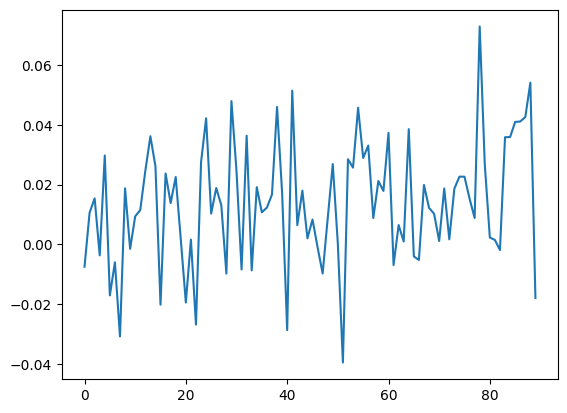

In [15]:
plt.figure()
plt.plot(np.nanmean(clean_active_beta, axis=0))

Plot PC Components & Variance

In [ ]:
trial_indices, pca_components, pca_mean = None, None, None

num_trials = beta_valume_clean_2d.shape[-1]
trial_idx = np.arange(num_trials) if trial_indices is None else np.unique(np.asarray(trial_indices, int).ravel())
# behavior_subset = behavior_matrix[trial_idx]
X = clean_active_bold[:, trial_idx, :]

# ----- apply PCA -----
print("PCA...", flush=True)
X_reshap = X.reshape(X.shape[0], -1).astype(np.float32)

if pca_components is None or pca_mean is None:
    pca = PCA()
    X_pca_full = pca.fit_transform(X_reshap.T).astype(np.float32)
    components = pca.components_.astype(np.float32)
    mean = pca.mean_.astype(np.float32)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.searchsorted(cumulative_variance, 0.95) + 1
    components = components[:n_components]
    X_pca = X_pca_full[:, :n_components]
else:
    components = pca_components.astype(np.float32)
    mean = pca_mean.astype(np.float32)
    n_components = components.shape[0]
    X_centered = X_reshap.T - mean
    X_pca = (X_centered @ components.T).astype(np.float32)

beta_reduced = np.nan_to_num(beta_valume_clean_2d.T - mean) @ components.T
beta_reduced = beta_reduced.T
print("Beta reduced shape:", beta_reduced.shape, flush=True)


In [ ]:
# fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# for data, name, ax in [(X_reshap, "Voxel", axes[0]), (X_pca, "Component", axes[1])]:
#     for idx, trace in enumerate(data[:2], start=1):
#         ax.plot(trace, label=f"{name} {idx}")
#     ax.set_title(f"{name} Time Series")
#     ax.set_xlabel("Time points")
#     ax.set_ylabel("Amplitude")

# axes[0].legend(loc="center right")
# axes[1].legend(loc="upper right")
# fig.tight_layout()

# fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
# for idx, trace in enumerate(beta_valume_clean_2d[:2], start=1):
#     axes[0].plot(trace, label=f"Beta {idx}")
# axes[0].set_title("Beta Time Series")
# axes[0].set_xlabel("Time points")
# axes[0].set_ylabel("Amplitude")
# axes[0].legend(loc="upper right")


# for comp_idx in range(2):
#     ax = axes[comp_idx + 1]
#     ax.plot(beta_reduced[comp_idx], label=f"Component {comp_idx + 1}")
#     ax.set_title(f"Component {comp_idx + 1} Time Series")
#     ax.set_xlabel("Time points")
#     ax.set_ylabel("Amplitude")
#     ax.legend(loc="upper right")

# fig.tight_layout()


In [ ]:
# plt.figure()
# plt.plot(cumulative_variance * 100)
# plt.axhline(95, color='r', linestyle='--')
# tmp = np.where(cumulative_variance >= 0.95)[0][0]
# plt.axvline(tmp, color='r', linestyle='--')
# plt.text(tmp+1, 50, f'{tmp+1} components', color='black')
# plt.xlabel("Number of components")
# plt.ylabel("Cumulative variance explained (%)")
# plt.title("PCA cumulative variance on BOLD")
# plt.show()

In [ ]:
param_grid = {"alpha_var_bold": [0.05], "alpha_var_beta": [0.05], "alpha_behavior": [0.05]}

trial_len = 9

(L_task, L_var_bold, L_var_beta, L_behavior, behavior_weight_avg_components, 
behavior_penalty_components, selected_BOLD_flat, pca_components, pca_mean) = calculate_matrices(beta_valume_clean_2d, 
                                                            clean_active_bold, mask_2d, behavior_matrix, None, trial_len)

In [10]:
L_task = np.load('/home/zkavian/Thesis_code_Glm_Opt/results_regressors_shuffled/L_task.npy')
L_var_beta = np.load('/home/zkavian/Thesis_code_Glm_Opt/results_regressors_shuffled/L_var_beta.npy')
L_var_bold =  np.load('/home/zkavian/Thesis_code_Glm_Opt/results_regressors_shuffled/L_var_bold.npy')
L_behav = np.load('/home/zkavian/Thesis_code_Glm_Opt/results_regressors_shuffled/L_behavior.npy')

In [ ]:
from matplotlib import colors

tmp = np.diag(L_task / np.max(L_task))
mask = np.isclose(tmp, 1.0)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
ranges = [(0, 20), (20, 40), (40, 60)]

for ax, (start, end) in zip(axes, ranges):
    data = tmp[start:end, start:end]
    data_mask = mask[start:end, start:end]
    sns.heatmap(data, ax=ax, cmap="jet", cbar=ax)
    ax.set(xlabel="component", ylabel="component", title=f"C_task ({start}–{end})")
    ax.invert_yaxis()

    tick_idx = np.linspace(0, data.shape[0] - 1, 5, dtype=int)
    tick_labels = np.linspace(start, end, 5, dtype=int)
    ax.set_xticks(tick_idx)
    ax.set_xticklabels(tick_labels)
    ax.set_yticks(tick_idx)
    ax.set_yticklabels(tick_labels)

fig.tight_layout()
plt.show()



# --- L_var_bold heatmap ---
tmp = np.diag(L_behav / np.max(L_behav))
mask = np.isclose(tmp, 1.0)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
ranges = [(0, 20), (20, 40), (40, 60)]

for ax, (start, end) in zip(axes, ranges):
    data = tmp[start:end, start:end]
    data_mask = mask[start:end, start:end]
    sns.heatmap(data, ax=ax, cmap="jet", cbar=ax)
    ax.set(xlabel="component", ylabel="component", title=f"C_behav ({start}–{end})")
    ax.invert_yaxis()

    tick_idx = np.linspace(0, data.shape[0] - 1, 5, dtype=int)
    tick_labels = np.linspace(start, end, 5, dtype=int)
    ax.set_xticks(tick_idx)
    ax.set_xticklabels(tick_labels)
    ax.set_yticks(tick_idx)
    ax.set_yticklabels(tick_labels)

fig.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

fig_task, ax_task = plt.subplots(figsize=(6, 4))
sns.lineplot(x=np.arange(L_task.shape[0]), y=L_task / np.max(L_task), ax=ax_task, color="steelblue")
ax_task.set(xlabel="Index", ylabel="L_task", title="Task Vector")
fig_task.tight_layout()
plt.show()

fig_task, ax_task = plt.subplots(figsize=(6, 4))
sns.lineplot(x=np.arange(L_behav.shape[0]), y=L_behav / np.max(L_behav), ax=ax_task, color="steelblue")
ax_task.set(xlabel="Index", ylabel="L_behav", title="Behaviour Vector")
fig_task.tight_layout()
plt.show()

In [ ]:
fig_hist, hist_axes = plt.subplots(2,2, figsize=(18, 4))

sns.histplot(L_task/np.max(L_task), bins=30, ax=hist_axes[0,0], color="steelblue")
hist_axes[0,0].set(xlabel="L_task", ylabel="Count", title="C_task Distribution")
hist_axes[0,0].set_yscale("log")

sns.histplot(L_behav/np.max(L_behav), bins=30, ax=hist_axes[0,1], color="steelblue")
hist_axes[0,1].set(xlabel="L_behav", ylabel="Count", title="C_behav Distribution")
hist_axes[0,1].set_yscale("log")

sns.histplot(L_var_beta.ravel()/np.max(L_var_beta), bins=30, ax=hist_axes[1,0], color="seagreen")
hist_axes[1,0].set(xlabel="Value", ylabel="Count", title="C_beta Distribution")
hist_axes[1,0].set_yscale("log")

sns.histplot(L_var_bold.ravel()/np.max(L_var_bold), bins=30, ax=hist_axes[1,1], color="darkmagenta")
hist_axes[1,1].set(xlabel="Value", ylabel="Count", title="C_bold Distribution")
hist_axes[1,1].set_yscale("log")

plt.tight_layout()
plt.show()

In [ ]:
from matplotlib import colors

tmp = L_var_beta / np.max(L_var_beta)
mask = np.isclose(tmp, 1.0)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
ranges = [(0, 20), (20, 40), (40, 60)]

for ax, (start, end) in zip(axes, ranges):
    data = tmp[start:end, start:end]
    data_mask = mask[start:end, start:end]
    sns.heatmap(data, ax=ax, cmap="jet", cbar=ax)
    ax.set(xlabel="component", ylabel="component", title=f"C_beta ({start}–{end})")
    ax.invert_yaxis()

    tick_idx = np.linspace(0, data.shape[0] - 1, 5, dtype=int)
    tick_labels = np.linspace(start, end, 5, dtype=int)
    ax.set_xticks(tick_idx)
    ax.set_xticklabels(tick_labels)
    ax.set_yticks(tick_idx)
    ax.set_yticklabels(tick_labels)

fig.tight_layout()
plt.show()



# --- L_var_bold heatmap ---
tmp = L_var_bold / np.max(L_var_bold)
mask = np.isclose(tmp, 1.0)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
ranges = [(0, 20), (20, 40), (40, 60)]

for ax, (start, end) in zip(axes, ranges):
    data = tmp[start:end, start:end]
    data_mask = mask[start:end, start:end]
    sns.heatmap(data, ax=ax, cmap="jet", cbar=ax)
    ax.set(xlabel="component", ylabel="component", title=f"C_bold ({start}–{end})")
    ax.invert_yaxis()

    tick_idx = np.linspace(0, data.shape[0] - 1, 5, dtype=int)
    tick_labels = np.linspace(start, end, 5, dtype=int)
    ax.set_xticks(tick_idx)
    ax.set_xticklabels(tick_labels)
    ax.set_yticks(tick_idx)
    ax.set_yticklabels(tick_labels)

fig.tight_layout()
plt.show()

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

s1, s2, s3 = 0.05, 0.05, 0.05
voxel_space_weights = np.load(f'results_regressors_shuffled/{s1}_{s2}_{s3}_voxel_space_weights.npy') #(314734,)
weights = np.load(f'results_regressors_shuffled/{s1}_{s2}_{s3}_weights.npy') # (588,)

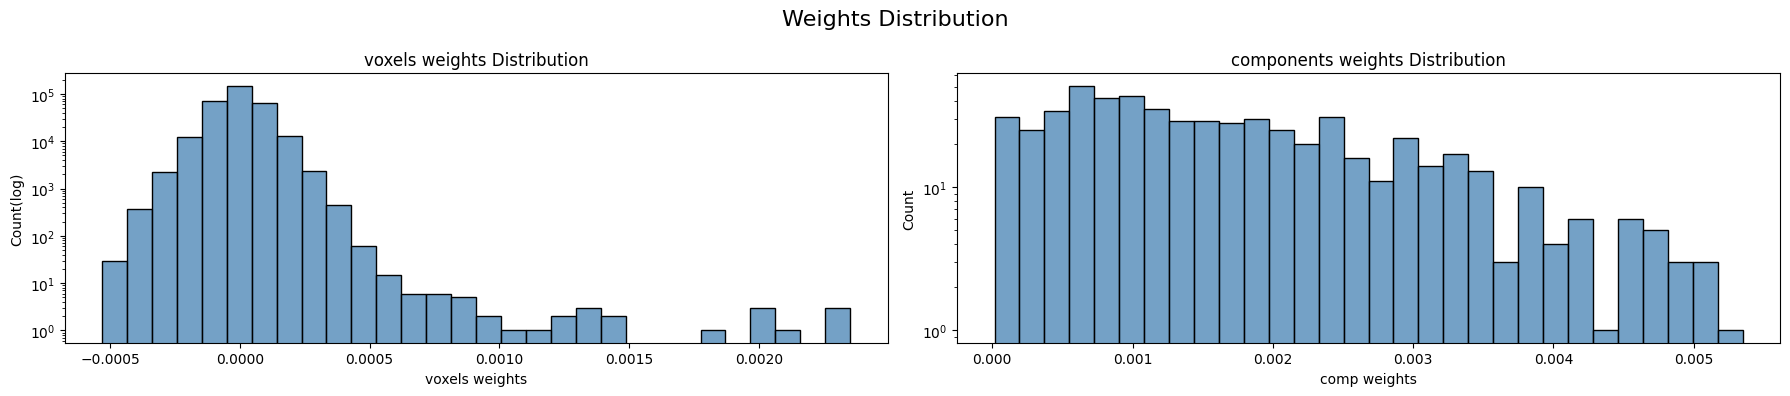

In [16]:
fig_hist, hist_axes = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(voxel_space_weights, bins=30, ax=hist_axes[0], color="steelblue")
hist_axes[0].set(xlabel="voxels weights", ylabel="Count(log)", title="voxels weights Distribution")
hist_axes[0].set_yscale("log")

sns.histplot(weights, bins=30, ax=hist_axes[1], color="steelblue")
hist_axes[1].set(xlabel="comp weights", ylabel="Count", title="components weights Distribution")
hist_axes[1].set_yscale("log")

plt.suptitle("Weights Distribution", fontsize=16)
plt.tight_layout()

In [17]:
# s1, s2, s3 = 0.05, 0.05, 0.05
# voxel_space_weights = np.load(f'results_regressors/{s1}_{s2}_{s3}_voxel_space_weights.npy') #(314734,)
# weights = np.load(f'results_regressors/{s1}_{s2}_{s3}_weights.npy') # (588,)

from nilearn.image import smooth_img
weight_vol = np.zeros(bold_data.shape[:3], dtype=np.float32)
active_coords_kept = tuple(coord[active_keep_mask] for coord in active_coords)
weight_vol[active_coords_kept] = np.abs(voxel_space_weights)

# lowe, upper = 0.0004, 0.002
# mask = (weight_vol >= lowe) & (weight_vol <= upper)
# weight_vol = np.where(mask, weight_vol, np.nan)
weight_vol = np.clip(weight_vol, None, 0.0005)

# weight_vol_smoothed = gaussian_filter(weight_vol, sigma=0.3)
weight_img = nib.Nifti1Image(weight_vol, bold_img.affine)
weight_img_resamp = resample_to_img(weight_img, anat_img, interpolation="continuous")

view = plotting.view_img(
    weight_img_resamp,
    bg_img=anat_img,
    # threshold=np.percentile(voxel_space_weights, 95),
    # threshold=0.0,
    symmetric_cmap=False,
    cmap="jet",
    draw_cross=False,
    colorbar=False,
)
view.save_as_html(file_name=f'weights_map_{s1}_{s2}_{s3}regressor_shuffled.html')

/tmp/ipykernel_2456378/2408234740.py:17: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  weight_img_resamp = resample_to_img(weight_img, anat_img, interpolation="continuous")
/tmp/ipykernel_2456378/2408234740.py:17: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  weight_img_resamp = resample_to_img(weight_img, anat_img, interpolation="continuous")
/home/zkavian/.venvs/workspace/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [ ]:
np.min(weight_vol), np.max(weight_vol)

In [ ]:
components_data = np.load('/home/zkavian/Thesis_code_Glm_Opt/0.05_0.05_pca_components.npy') #(588, 588)
components_data.shape

In [123]:
voxel_space_weights = zscore(components_data, axis=0).T @ weights

In [ ]:
sns.histplot(voxel_space_weights, bins=30, color="steelblue")


In [ ]:
s1, s2, s3 = 0.05, 0.05, 0.05
voxel_space_weights = np.load(f'results_regressors/{s1}_{s2}_{s3}_voxel_space_weights.npy') #(314734,)
weights = np.load(f'results_regressors/{s1}_{s2}_{s3}_weights.npy') # (588,)

from nilearn.image import smooth_img
weight_vol = np.zeros(bold_data.shape[:3], dtype=np.float32)
active_coords_kept = tuple(coord[active_keep_mask] for coord in active_coords)
weight_vol[active_coords_kept] = np.abs(voxel_space_weights)

# lowe, upper = 0.0004, 0.002
# mask = (weight_vol >= lowe) & (weight_vol <= upper)
# weight_vol = np.where(mask, weight_vol, np.nan)
weight_vol = np.clip(weight_vol, None, 0.0005)

# weight_vol_smoothed = gaussian_filter(weight_vol, sigma=0.3)
weight_img = nib.Nifti1Image(weight_vol, bold_img.affine)
weight_img_resamp = resample_to_img(weight_img, anat_img, interpolation="continuous")

view = plotting.view_img(
    weight_img_resamp,
    bg_img=anat_img,
    # threshold=np.percentile(voxel_space_weights, 95),
    # threshold=0.0,
    symmetric_cmap=False,
    cmap="jet",
    draw_cross=False,
    colorbar=False,
)
view.save_as_html(file_name=f'weights_map_{s1}_{s2}_{s3}regressor_zscore.html')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

fig, ax = plt.subplots(figsize=(12, 7))
tmp = beta.ravel()

counts, bins, _ = ax.hist(tmp, bins=100, density=False, color='C0', alpha=0.85, edgecolor='none')
ax.set_title('All beta')
ax.set_xlabel('beta')
ax.set_ylabel('Count')
ax.grid(False)

ranges = [(-500,-20),(-1000,-500),(-2000,-1000), (100, 5000), (5000, 10000), (10000, 15000), (15000, 20000),(-20,20)]
colors = ['C7','C6','C5','C1', 'C2', 'C3', 'C4','C8']
positions = [
    [0.3, 0.5, 0.1, 0.10],
    [0.5, 0.5, 0.1, 0.10],
    [0.8, 0.5, 0.1, 0.10],
    [0.3, 0.2, 0.1, 0.10],
    [0.3, 0.7, 0.1, 0.10],
    [0.8, 0.2, 0.1, 0.10],
    [0.8, 0.7, 0.1, 0.10],
    [0.5, 0.2, 0.2, 0.20]
]

ymax = counts.max()

for (lo, hi), color, pos in zip(ranges, colors, positions):
    # rect = patches.Rectangle((lo, 0), hi - lo, ymax, linewidth=1.5,
    #                          edgecolor=color, facecolor='none', linestyle='--')
    # ax.add_patch(rect)

    axins = fig.add_axes(pos)
    mask = (tmp >= lo) & (tmp < hi)
    axins.hist(tmp[mask], bins=np.linspace(lo, hi, 20), density=False,
               color=color, alpha=0.85, edgecolor='none')
    axins.set_xlim(lo, hi)
    # axins.set_ylim(0, ymax)
    axins.set_title(f'{lo:.0f}–{hi:.0f}', fontsize=9)
    axins.tick_params(axis='both', labelsize=7)
    axins.grid(False)
    # axins.set_yticks([])

fig.tight_layout()


In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
tmp = clean_beta.ravel()
ax.hist(tmp, density=False, bins=100)
ax.set_title('Cleaned beta')
ax.set_xlabel('beta')
ax.set_ylabel('Count')
ax.set_xlim(np.nanmin(tmp), np.nanmax(tmp))
ax.grid(False)

In [9]:
tmp = np.load('/home/zkavian/Thesis_code_Glm_Opt/results_regressors/behavior_penalty_components.npy')
tmp.shape

(588,)

In [ ]:
tmp = np.load('/home/zkavian/Thesis_code_Glm_Opt/results_regressors/behavior_weight_avg_components.npy')
tmp.shape

In [18]:
import pandas as pd

In [23]:
results = np.load('behavior_regression_summary.npy', allow_pickle=True)

In [ ]:
pd.DataFrame(results)

In [34]:
summary = (pd.DataFrame.from_records(results)
             .sort_values('mse')
             .head(10))
print(summary.to_string(index=False))


 component      mse       r2      fro      alpha
       439 0.794628 0.205372 0.001081 110.365409
       346 0.836586 0.163414 0.000897 106.776799
       300 0.849009 0.150991 0.000769 138.898806
       380 0.850445 0.149555 0.000602 206.127818
       425 0.867159 0.132841 0.000794 128.124384
       149 0.880284 0.119716 0.000437 252.471965
       514 0.881783 0.118217 0.000790 169.609056
        98 0.883890 0.116110 0.000432 232.691174
       253 0.886504 0.113496 0.000558 179.791770
       426 0.887867 0.112133 0.000605 188.206941


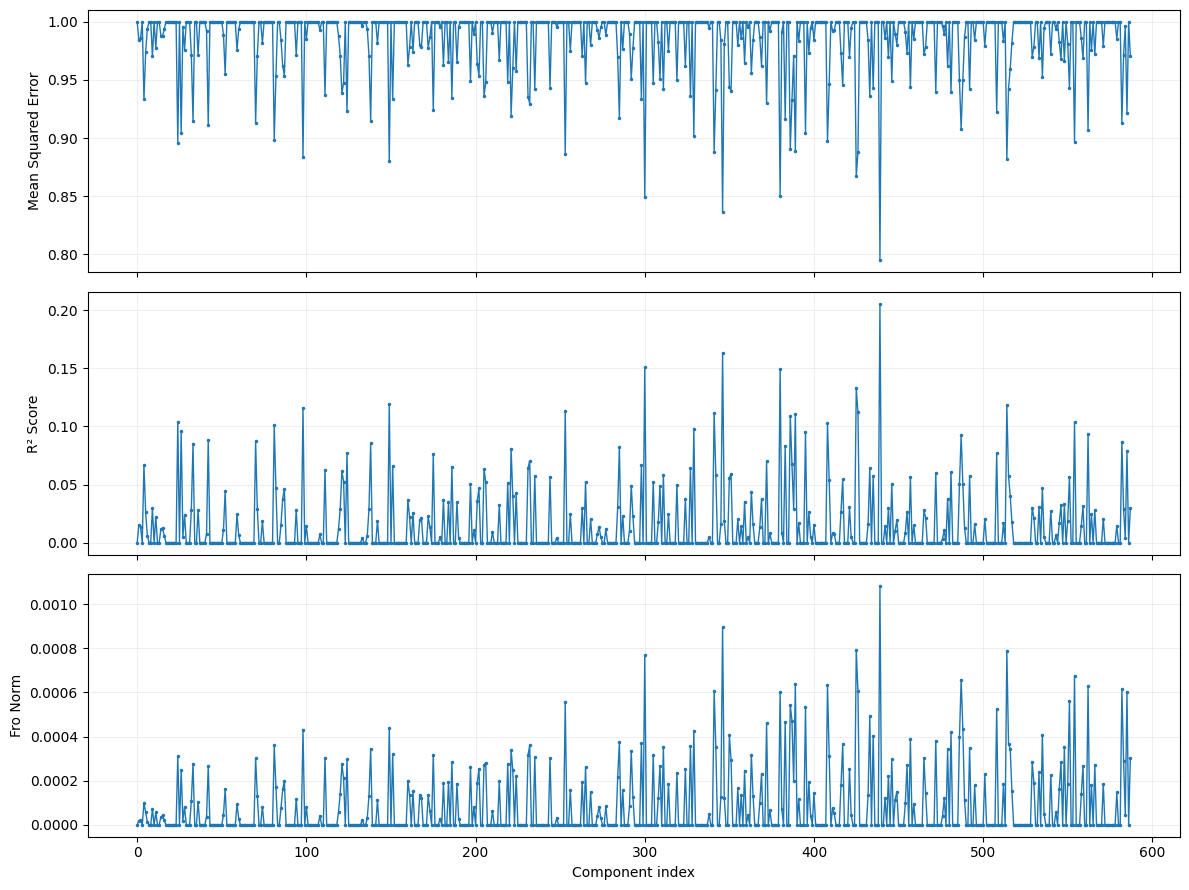

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

results = np.load("behavior_regression_summary.npy", allow_pickle=True)
df = pd.DataFrame.from_records(results).sort_values("component")

fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
metrics = [("mse", "Mean Squared Error"), ("r2", "R² Score"), ("fro", "Fro Norm")]

for ax, (col, label) in zip(axes, metrics):
    ax.plot(df["component"], df[col], marker=".", linewidth=1, markersize=3)
    ax.set_ylabel(label)
    ax.grid(alpha=0.2)

axes[-1].set_xlabel("Component index")
# fig.suptitle("Behavior Regression Metrics by Component", fontsize=16, y=0.95)
plt.tight_layout()
plt.savefig("behavior_regression_metrics.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
best = results[np.argmin([r["mse"] for r in results])]
comp = X_components[best["component"]][finite_mask]
reg = best["estimator"]      # store `reg` if you need coefficients
preds = reg.predict(comp)
fig, axes = plt.subplots(len(metric_names), 1, figsize=(6, 2*len(metric_names)))
for j, ax in enumerate(np.atleast_1d(axes)):
    ax.plot(preds[:, j], label="pred", alpha=0.7)
    ax.plot(y_target[:, j], label="true", alpha=0.7)
    ax.set_title(metric_names[j])
fig.legend()


In [37]:
best = results[np.argmin([r["mse"] for r in results])]
reg = best["estimator"]      
plt.imshow(reg.coef_, aspect="auto")

KeyError: 'estimator'

In [38]:
best

{'component': 439,
 'mse': 0.7946278627290125,
 'r2': 0.2053721372709876,
 'fro': 0.0010811478132382035,
 'alpha': 110.36540933191566}